In [146]:
from typing import Tuple
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from lab1.Lab1_FK_answers import *
import scripts as s
import importlib

importlib.reload(s)

<module 'scripts' from 'C:\\Users\\Alfred\\Documents\\games105\\lab1\\drafts\\scripts.py'>

In [142]:
bvh = "..\\data\\simple.bvh"
joint_name, joint_parent, joint_offset = part1_calculate_T_pose(bvh)
motion_data = load_motion_data(bvh)
joint_positions, joint_orientations = part2_forward_kinematics(joint_name, joint_parent, joint_offset, motion_data, 0)
current_joint_offsets = (joint_positions - joint_positions[joint_parent])
current_joint_offsets[0].fill(0.)

target = np.array([1., 1., 1.])

path = [0, 1, 2]
# joint_name, joint_parent, joint_offset, motion_data, joint_positions, joint_orientations
current_joint_offsets 

array([[0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

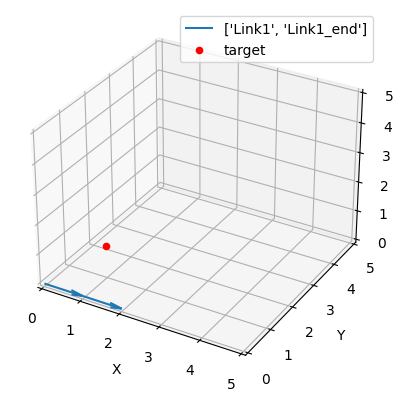

In [132]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(joint_positions[joint_parent][path, 0], 
          joint_positions[joint_parent][path, 1], 
          joint_positions[joint_parent][path, 2], 
          current_joint_offsets[path, 0], 
          current_joint_offsets[path, 1], 
          current_joint_offsets[path, 2], label=joint_name[1:])

# ax.quiver(joint_positions[joint_parent][1:, 0], joint_positions[joint_parent][1:, 1], joint_positions[joint_parent][1:, 2], 
#           current_joint_offsets[:, 0], 
#           current_joint_offsets[:, 1], 
#           current_joint_offsets[:, 2], label=joint_name[1:])

# for i in range(1, joint_positions.shape[0]):
#     ax.quiver(joint_positions[joint_parent[i], 0], joint_positions[joint_parent[i], 1], joint_positions[joint_parent[i], 2], 
#           current_joint_offsets[i, 0], 
#           current_joint_offsets[i, 1], 
#           current_joint_offsets[i, 2], label=joint_name[i])

ax.scatter(target[0], target[1], target[2], c='r', marker='o', label='target')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(0, 5)  # Set X-axis limits
ax.set_ylim(0, 5)  # Set Y-axis limits
ax.set_zlim(0, 5)  # Set Z-axis limits

ax.legend()

In [ ]:
# compute end-effector gradient
# compute loss function gradient
# update orientations
# update positions
# repeat

#### compute end-effector gradient

In [90]:
current_joint_offsets

array([[-2.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [93]:
I = np.eye(3)
jacobian_transpose = np.cross(I, current_joint_offsets[path[1:], None, :]).reshape(-1, 3)
jacobian_transpose

array([[ 0.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  1.,  0.]])

#### loss function gradient

In [97]:
error = joint_positions[path[-1]] - target
print(f"end_position:\n{joint_positions[path[-1]]}\n"
      f"target:\n{target}\n"
      f"error = end_positions - target:\n{error}")

end_position:
[2. 0. 0.]
target:
[1. 1. 1.]
error = end_positions - target:
[ 1. -1. -1.]


In [98]:
loss_gradient = jacobian_transpose @ error
loss_gradient

array([ 0.,  1., -1.,  0.,  1., -1.])

#### update orientations

In [99]:
learning_rate = 0.1
update = - learning_rate * loss_gradient
update

array([-0. , -0.1,  0.1, -0. , -0.1,  0.1])

In [100]:
update.reshape(-1, 3)

array([[-0. , -0.1,  0.1],
       [-0. , -0.1,  0.1]])

In [101]:
rotations = R.from_euler("XYZ", update.reshape(-1, 3))
rotations.as_matrix()

array([[[ 0.99003329, -0.09933467, -0.09983342],
        [ 0.09983342,  0.99500417,  0.        ],
        [ 0.09933467, -0.00996671,  0.99500417]],

       [[ 0.99003329, -0.09933467, -0.09983342],
        [ 0.09983342,  0.99500417,  0.        ],
        [ 0.09933467, -0.00996671,  0.99500417]]])

In [102]:
joint_orientations

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [104]:
joint_orientations[path[:-1]]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [106]:
current_orientations = R.from_quat(joint_orientations[path[:-1]])
current_orientations.as_matrix()

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]])

In [117]:
(rotations * current_orientations).as_quat()

array([[-0.00249792, -0.04991671,  0.04991671,  0.99750208],
       [-0.00249792, -0.04991671,  0.04991671,  0.99750208]])

In [123]:
result_orientations = R.from_quat(joint_orientations)
result_orientations[path[:-1]] = rotations * result_orientations[path[:-1]]
result_orientations.as_quat(), joint_orientations

(array([[-0.00249792, -0.04991671,  0.04991671,  0.99750208],
        [-0.00249792, -0.04991671,  0.04991671,  0.99750208],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]))

#### update positions

In [141]:
initial_root = np.array([0., 0., 0.])
result_positions = pose_joint_positions(initial_root,
                                               joint_parent,
                                               joint_offset,
                                               result_orientations)
result_positions, joint_positions

(array([[0.        , 0.        , 0.        ],
        [0.99003329, 0.09983342, 0.09933467],
        [1.98006658, 0.19966683, 0.19866933]]),
 array([[0., 0., 0.],
        [1., 0., 0.],
        [2., 0., 0.]]))

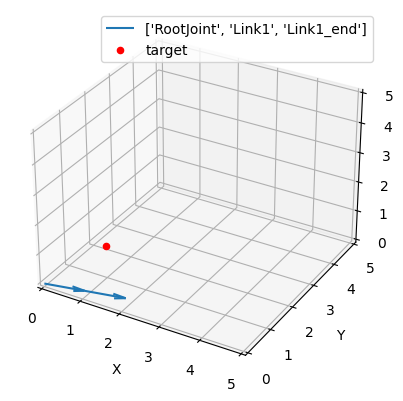

In [138]:
s.plot_manipulator(result_positions,
                   joint_parent,
                   path,
                   target,
                   joint_name)

Positions:
[[0.         0.         0.        ]
 [0.58350861 0.57435903 0.57413361]
 [1.16701721 1.14871807 1.14826723]]
Orientations:
[[-0.00749977 -0.32532619  0.32001339  0.88977416]
 [-0.00749977 -0.32532619  0.32001339  0.88977416]
 [ 0.          0.          0.          1.        ]]


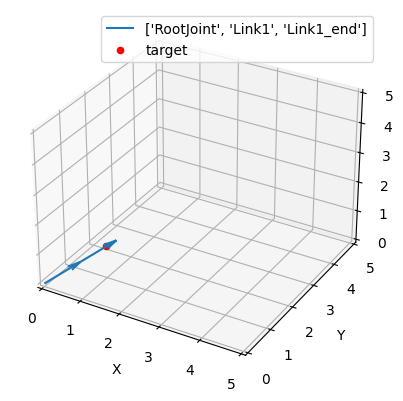

In [174]:
test_positions, test_orientations = s.gradient_descent(test_positions, test_orientations, joint_parent, joint_offset, initial_root, path, target)

s.plot_manipulator(test_positions,
                   joint_parent,
                   path,
                   target,
                   joint_name)
print(f"Positions:\n{test_positions}\n"
      f"Orientations:\n{test_orientations}")

In [110]:
(R.from_euler("XYZ", [[10, 0, 0],
                     [0, 10, 0]], degrees=True) * R.from_euler("XYZ", [[5, 0, 0], 
                                                                       [0, 5, 0]], degrees=True)).as_matrix()

array([[[ 1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.96592583, -0.25881905],
        [ 0.        ,  0.25881905,  0.96592583]],

       [[ 0.96592583,  0.        ,  0.25881905],
        [ 0.        ,  1.        ,  0.        ],
        [-0.25881905,  0.        ,  0.96592583]]])

In [111]:
(R.from_euler("XYZ", [10, 0, 0], degrees=True) * R.from_euler("XYZ", [5, 0, 0], degrees=True)).as_matrix()

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.96592583, -0.25881905],
       [ 0.        ,  0.25881905,  0.96592583]])

In [112]:
(R.from_euler("XYZ", [0, 10, 0], degrees=True) * R.from_euler("XYZ", [0, 5, 0], degrees=True)).as_matrix()

array([[ 0.96592583,  0.        ,  0.25881905],
       [ 0.        ,  1.        ,  0.        ],
       [-0.25881905,  0.        ,  0.96592583]])

In [ ]:
def finite_difference():
    pass


def jacobian_transpose() -> Tuple[np.ndarray, np.ndarray]:
    """Return final joint positions and orientations"""
    pass